In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tensorflow
%pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

## Data preparation

In [ ]:
image_dir = Path("data/images")

# Get the image file paths and extract the labels of these filepaths
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Put the image filepath and labels in a dataframe
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)

# Use a smaller sample size, for lower training time (also lower accuracy though)
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [9]:
# This is what the dataframe looks like
image_df

,Filepath,Label
0,data\images\paella\1769909.jpg,paella
1,data\images\steak\2815172.jpg,steak
2,data\images\bread_pudding\272991.jpg,bread_pudding
3,data\images\waffles\1854304.jpg,waffles
4,data\images\french_toast\3009499.jpg,french_toast
...,...,...
10095,data\images\croque_madame\3389786.jpg,croque_madame
10096,data\images\poutine\227190.jpg,poutine
10097,data\images\breakfast_burrito\790446.jpg,breakfast_burrito
10098,data\images\guacamole\2979136.jpg,guacamole


In [ ]:
# Train test split of 70% training size and 30% testing size
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

## Image data loader

In [ ]:
# Training data generator with 20% validation split 
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

# Test data generator  
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Create data flows for training, validation, and testing
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


## Model architecture

In [ ]:
# Load pre-trained MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Add 3 new custom layers
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

# Combine into a final model
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

C:\Users\brech\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 173s 969ms/step - accuracy: 0.0673 - loss: 4.3112 - val_accuracy: 0.2744 - val_loss: 2.9754
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - accuracy: 0.3806 - loss: 2.4799 - val_accuracy: 0.3600 - val_loss: 2.5547
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 40s 224ms/step - accuracy: 0.5111 - loss: 1.8333 - val_accuracy: 0.3868 - val_loss: 2.4445
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 28s 158ms/step - accuracy: 0.6167 - loss: 1.4692 - val_accuracy: 0.3720 - val_loss: 2.5759
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 27s 152ms/step - accuracy: 0.6867 - loss: 1.1721 - val_accuracy: 0.3897 - val_loss: 2.4863
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 27s 153ms/step - accuracy: 0.7737 - loss: 0.8583 - val_accuracy: 0.4059 - val_loss: 2.5286


## Evaluation

In [ ]:
# Calculate test accuracy
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.09%


In [ ]:
# Generate predictions
predictions = np.argmax(model.predict(test_images), axis=1)

# Calculate confusion matrix and classification report
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step


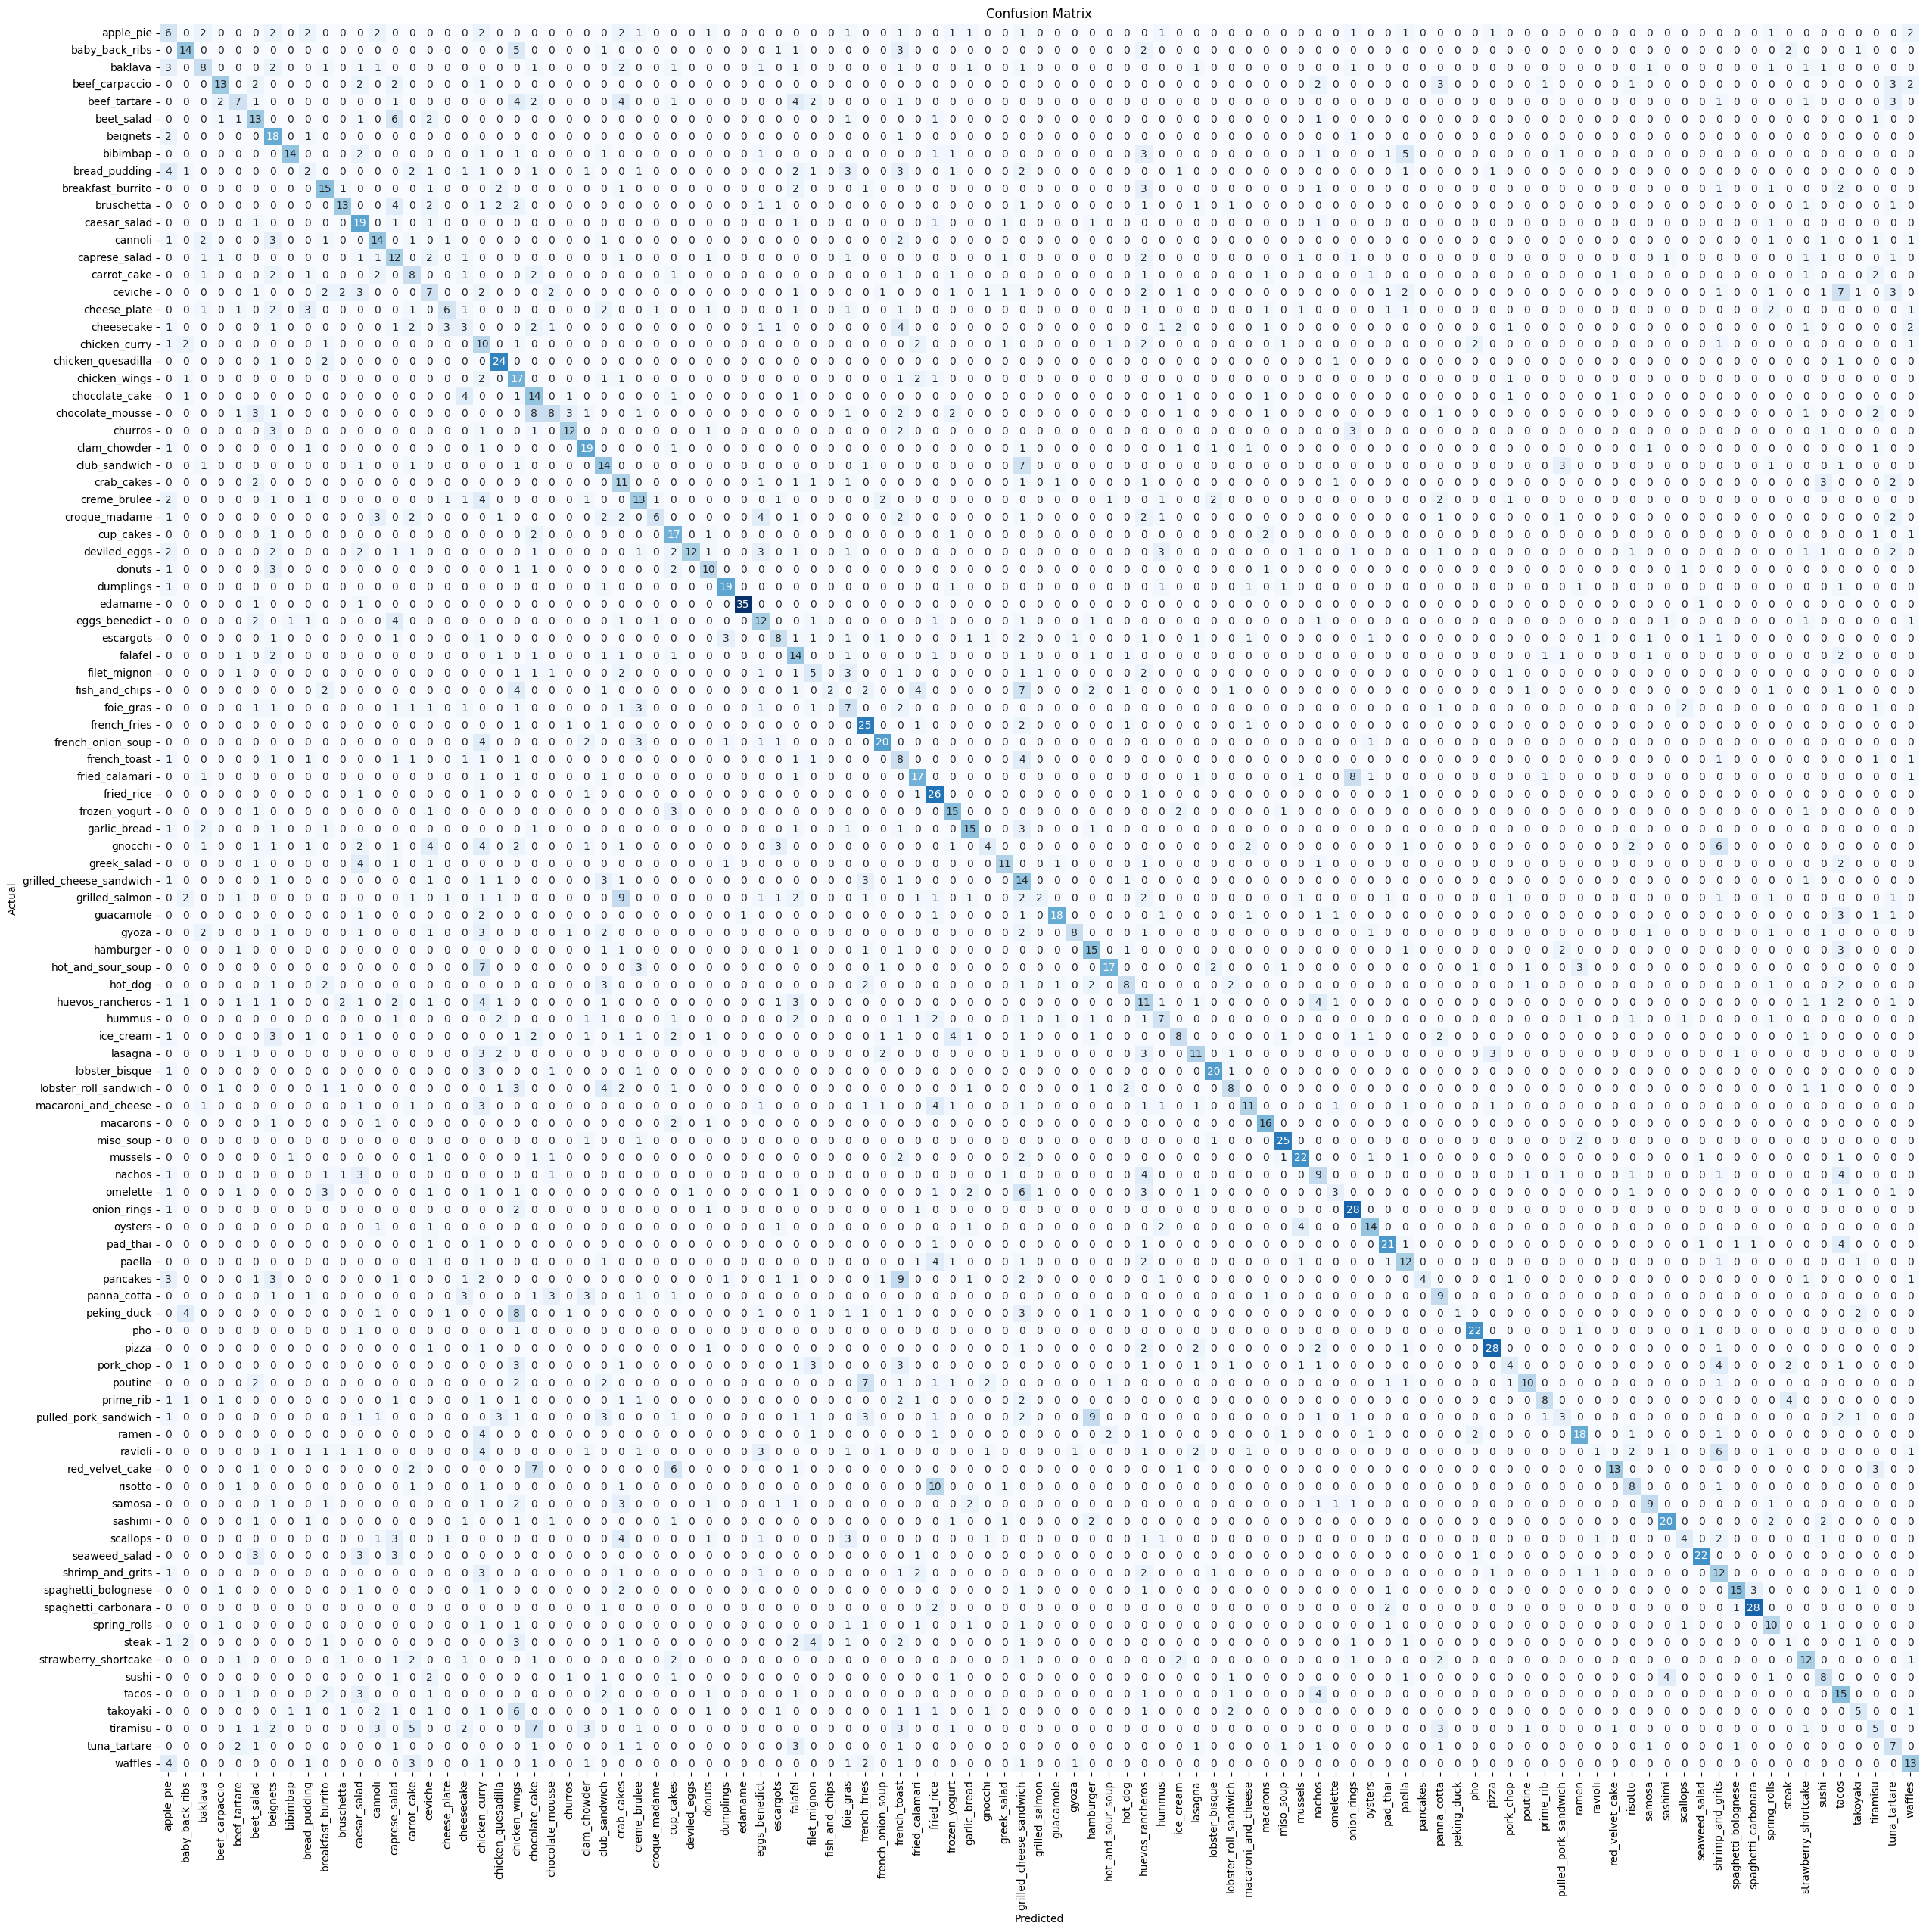

In [ ]:
# Show Confusion matrix
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Show classification report
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.13      0.19      0.15        32
         baby_back_ribs       0.47      0.47      0.47        30
                baklava       0.35      0.26      0.30        31
         beef_carpaccio       0.62      0.41      0.49        32
           beef_tartare       0.30      0.21      0.25        34
             beet_salad       0.32      0.46      0.38        28
               beignets       0.28      0.78      0.41        23
               bibimbap       0.82      0.42      0.56        33
          bread_pudding       0.10      0.07      0.08        30
      breakfast_burrito       0.41      0.48      0.44        31
             bruschetta       0.57      0.41      0.47        32
           caesar_salad       0.33      0.68      0.44        28
                cannoli       0.42      0.47      0.44        30
          caprese_salad       0.23      0.

In [ ]:
# Save trained model
model.save('food_classification_model.h5')

NameError: name 'load_model' is not defined

In [ ]:
import pickle
# Save class labels
class_labels = list(train_images.class_indices.keys())
with open('class_labels.pkl', 'wb') as f:
    pickle.dump(class_labels, f)

In [22]:
class_labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster